In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import polars as pl

import predicting_unseen_tasks.directories as dirs


DATA_DIR = dirs.get_data_dir()
mteb = pl.read_parquet(DATA_DIR / "mteb_data.parquet")

In [2]:
single_language = (
    mteb.with_columns(
        pl.col("languages").list.first().alias("language"),
        pl.col("languages").list.len().alias("num_languages"),
    )
    .filter(pl.col("num_languages") == 1)
    .drop("languages")
)
example_model = single_language.with_columns(
    pl.col("model_name").first().alias("first_model")
).filter(pl.col("first_model") == pl.col("model_name"))

## Hypotheses to test
One potential research question would be something vaguely like "Does domain knowledge transfer across languages?". The idea here would be to investigate composability of capabilities in a fairly constrained way. Specifically, we want to investigate whether domain knowledge is language independent.

My feeling is that this would be most rigorously answered with a LMER model with `model_name` as a random effect. However, a "simpler" way would be to look at the correlation between tasks in the same domain but in different languages. I'll try below for the example_model.

In [3]:
def iou(col1: str, col2: str) -> pl.Expr:
    return (
        pl.col(col1).list.set_intersection(pl.col(col2)).list.len()
        / pl.col(col1).list.set_union(pl.col(col2)).list.len()
    ).alias("overlap")


boring_categories = ["Written", "Spoken", "Non-fiction"]
tasks = (
    single_language.select("task", "domains")
    .with_columns(pl.col("domains").list.set_difference(boring_categories))
    .unique("task")
    .with_columns(pl.lit(1).alias("value"))
    .drop_nulls()
    .filter(pl.col("domains").list.len() > 0)
)
overlap = (
    tasks.join(tasks, on="value")
    .with_columns(iou("domains", "domains_right"))
    .select(["task", "task_right", "overlap"])
    .cast({pl.selectors.string(): pl.Categorical})
)

In [4]:
def calculate_model_corr_diff(domain_data: pl.DataFrame) -> float:
    assert domain_data["model_name"].n_unique() == 1, "Data must be from a single model"
    return (
        domain_data.join(domain_data, on="domains")
        .filter(pl.col("language") != pl.col("language_right"))
        .select("performance", "performance_right")
        .corr()["performance"][1]
    )


def calculate_model_corr_same(domain_data: pl.DataFrame) -> float:
    assert domain_data["model_name"].n_unique() == 1, "Data must be from a single model"
    return (
        domain_data.join(domain_data, on="domains")
        .filter(pl.col("language") == pl.col("language_right"))
        .filter(pl.col("task") != pl.col("task_right"))
        .select("performance", "performance_right")
        .corr()["performance"][1]
    )


join_data = single_language.cast({pl.selectors.string(): pl.Categorical}).drop(
    "model_name", "subset", "split", "num_languages", "domains"
)
prediction_data = (
    join_data.join(join_data, on=["revision", "task_type", "main_score_name"])
    .filter(pl.col("task") != pl.col("task_right"))
    .with_columns(
        (pl.col("language") == pl.col("language_right")).alias("same_language")
    )
)

In [5]:
prediction_data

revision,task,task_type,performance,main_score_name,language,task_right,performance_right,language_right,same_language
cat,cat,cat,f64,cat,cat,cat,f64,cat,bool
"""cfeb66885b598de483cc04eb08c7d9…","""ATEC""","""STS""",0.540323,"""cosine_spearman""","""cmn-Hans""","""AFQMC""",0.675485,"""cmn-Hans""",true
"""cfeb66885b598de483cc04eb08c7d9…","""BIOSSES""","""STS""",0.864767,"""cosine_spearman""","""eng-Latn""","""AFQMC""",0.675485,"""cmn-Hans""",false
"""cfeb66885b598de483cc04eb08c7d9…","""BQ""","""STS""",0.777189,"""cosine_spearman""","""cmn-Hans""","""AFQMC""",0.675485,"""cmn-Hans""",true
"""cfeb66885b598de483cc04eb08c7d9…","""LCQMC""","""STS""",0.727991,"""cosine_spearman""","""cmn-Hans""","""AFQMC""",0.675485,"""cmn-Hans""",true
"""cfeb66885b598de483cc04eb08c7d9…","""PAWSX""","""STS""",0.468727,"""cosine_spearman""","""cmn-Hans""","""AFQMC""",0.675485,"""cmn-Hans""",true
…,…,…,…,…,…,…,…,…,…
"""c791d37474fa6a5c72eb3a2522be34…","""StackExchangeClusteringP2P""","""Clustering""",0.47171,"""v_measure""","""eng-Latn""","""TwentyNewsgroupsClustering""",0.571523,"""eng-Latn""",true
"""c791d37474fa6a5c72eb3a2522be34…","""SprintDuplicateQuestions""","""PairClassification""",0.954388,"""max_ap""","""eng-Latn""","""TwitterSemEval2015""",0.814144,"""eng-Latn""",true
"""c791d37474fa6a5c72eb3a2522be34…","""TwitterURLCorpus""","""PairClassification""",0.879183,"""max_ap""","""eng-Latn""","""TwitterSemEval2015""",0.814144,"""eng-Latn""",true


In [6]:
corr_results = (
    prediction_data.join(overlap, on=["task", "task_right"])
    .with_columns((pl.col("overlap") > 0).alias("has_overlap"))
    .group_by("revision", "same_language", "has_overlap", "task_type")
    .agg(
        pl.corr("performance", "performance_right", method="pearson").alias(
            "correlation"
        )
    )
)

/var/folders/bd/m7_xt1cd097bwm56ny1027480000gn/T/ipykernel_31155/891103233.py:1: CategoricalRemappingWarning: Local categoricals have different encodings, expensive re-encoding is done to perform this merge operation. Consider using a StringCache or an Enum type if the categories are known in advance
  corr_results = prediction_data.join(overlap, on=["task", "task_right"]).with_columns((pl.col("overlap") > 0).alias("has_overlap")).group_by(


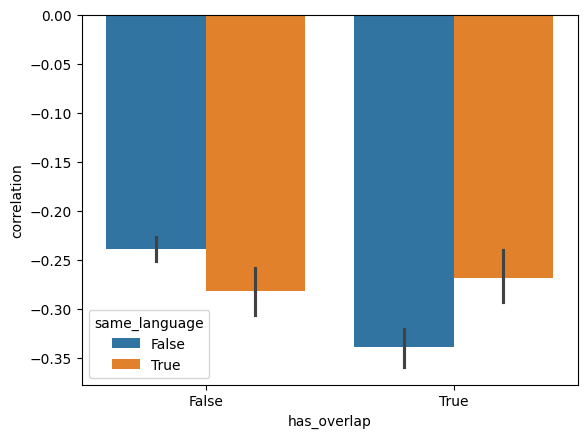

In [7]:
PLOT_DIR = dirs.get_plot_dir()
sns.barplot(data=corr_results, x="has_overlap", y="correlation", hue="same_language")
plt.savefig(PLOT_DIR / "correlation_overlap.png", bbox_inches="tight")